# Content of Chapter 2 - Neural Networks

In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import * 
from tqdm import tqdm
import matplotlib.pyplot as plt

### Functions from Chapter 1

In [2]:
def moveTo(obj, device): 
    """ 
    obj: the python object to move to a device, or to move its
    ➥ contents to a device
    device: the compute device to move objects to 
    """
    if isinstance(obj, list): 
        return [moveTo(x, device) for x in obj] 
    elif isinstance(obj, tuple): 
        return tuple(moveTo(list(obj), device)) 
    elif isinstance(obj, set): 
        return set(moveTo(list(obj), device)) 
    elif isinstance(obj, dict): 
        to_ret = dict() 
        for key, value in obj.items(): 
            to_ret[moveTo(key, device)] = moveTo(value, device) 
        return to_ret 
    elif hasattr(obj, "to"): 
        return obj.to(device) 
    else: 
        return obj

<Axes: >

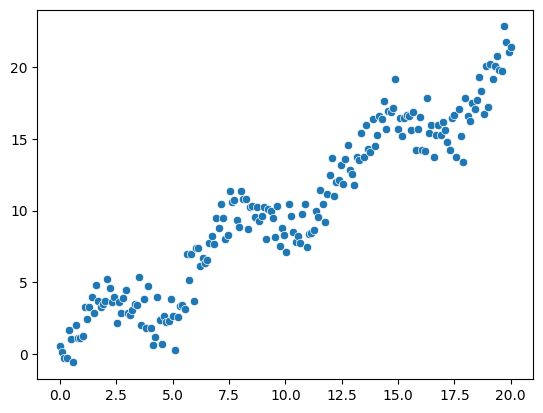

In [3]:
X = np.linspace(0, 20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [4]:
class Simple1DRegressionDataset(Dataset): 
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__() 
        self.X = X.reshape(-1,1) 
        self.y = y.reshape(-1,1) 
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self): 
        return self.X.shape[0] 
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [5]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"): 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)                    

    model.to(device)                                                             

    for epoch in tqdm(range(epochs), desc="Epoch"):                              
        model = model.train()                                                    
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):  
            inputs = moveTo(inputs, device)                                      
            labels = moveTo(labels, device)                                      

            optimizer.zero_grad()                                                


            y_hat = model(inputs)                                                

            loss = loss_func(y_hat, labels)                                      
            loss.backward()                                                      
            optimizer.step()                                                     
            running_loss += loss.item()    

In [6]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device('cuda')
train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


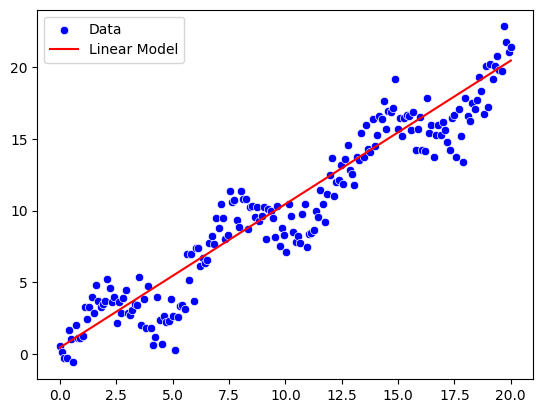

In [7]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 1),
)

train_simple_network(model, loss_func, training_loader, device=device)

Epoch:  50%|█████     | 10/20 [00:04<00:04,  2.20it/s]

Epoch: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


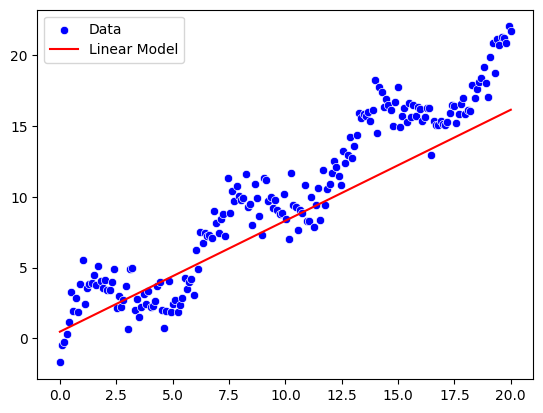

In [ ]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

### Introduce some non linearity to the system

Text(0, 0.5, 'Activation')

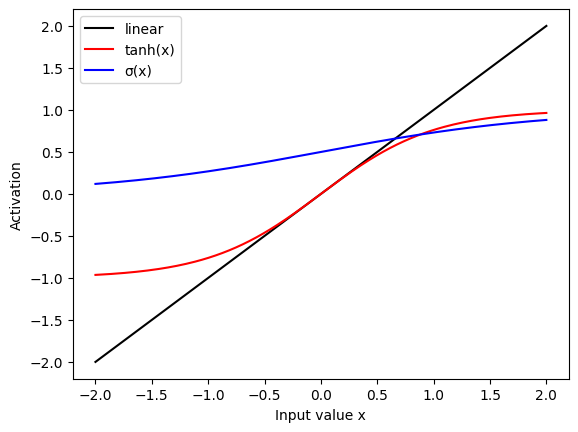

In [ ]:
activation_input = np.linspace(-2, 2, num=200) 
tanh_activation = np.tanh(activation_input) 
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)
 
sns.lineplot(x=activation_input, y=activation_input, color='black', label="linear") 
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)") 
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="σ(x)")

ax.set_xlabel('Input value x')
ax.set_ylabel('Activation')

Epoch: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


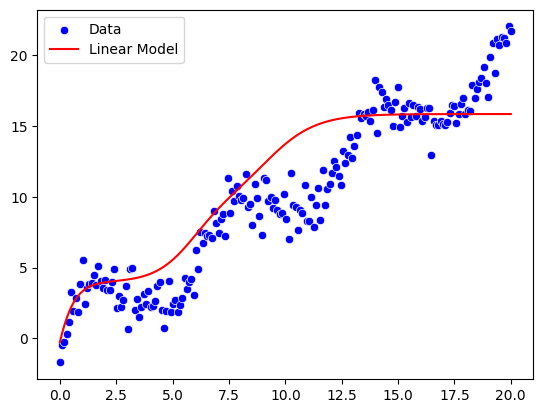

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
)

train_simple_network(model, loss_func, training_loader, device=device)

with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

<Axes: >

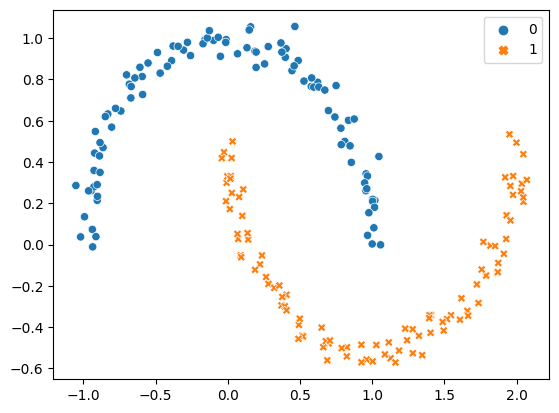

In [ ]:
from sklearn.datasets import make_moons 
X, y = make_moons(n_samples=200, noise=0.05) 
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)


In [ ]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [ ]:
in_features = 2 
out_features = 2 
model = nn.Linear(in_features, out_features)

In [ ]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


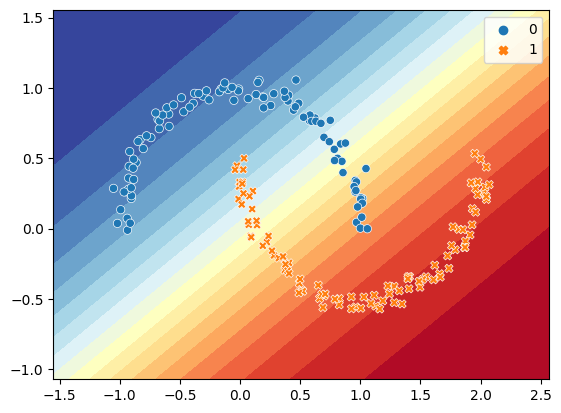

In [ ]:
def visualize2DSoftmax(X, y, model, title=None): 
    x_min = np.min(X[:,0])-0.5 
    x_max = np.max(X[:,0])+0.5 
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5 
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij') 
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1))) 
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32)) 
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu) 
    ax = plt.gca() 
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax) 
    if title is not None: 
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

In [ ]:
model = nn.Sequential( 
    nn.Linear(2, 30), 
    nn.Tanh(), 
    nn.Linear(30, 30), 
    nn.Tanh(), nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=250)

Epoch: 100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


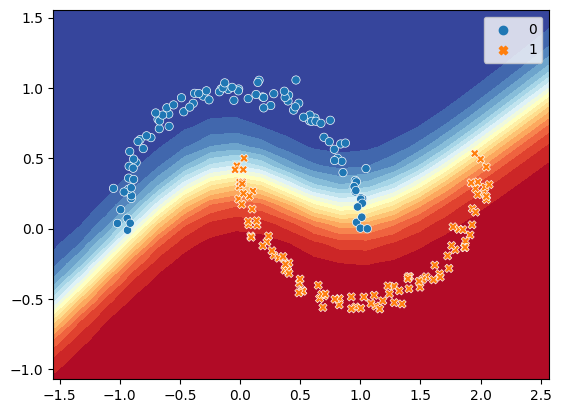

In [ ]:
visualize2DSoftmax(X, y, model)

In [ ]:
import time

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


In [ ]:
import pandas as pd

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
testing_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader, epochs=5, test_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})


Epoch: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


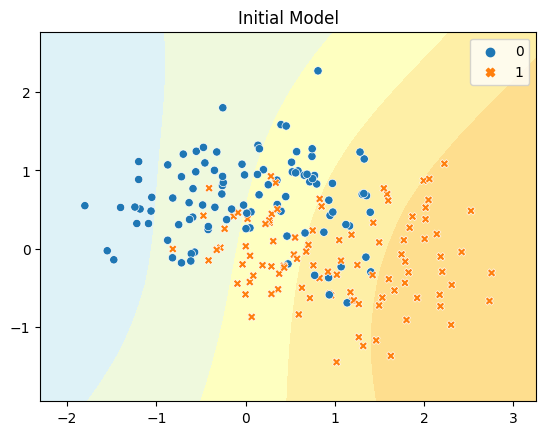

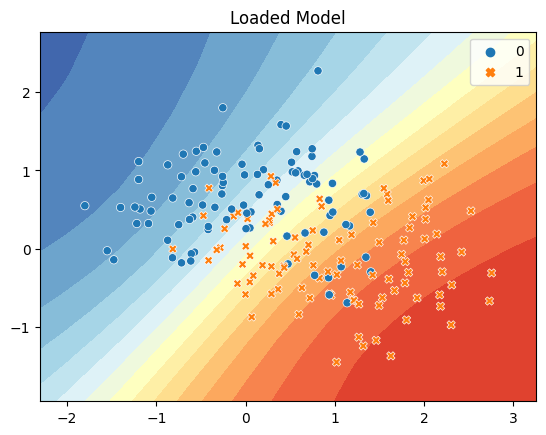

In [ ]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

checkpoint_dict = torch.load('model.pt', map_location=device)


model_new.load_state_dict(checkpoint_dict['model_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

### Exercise 1.0

use standard scaler

<Axes: >

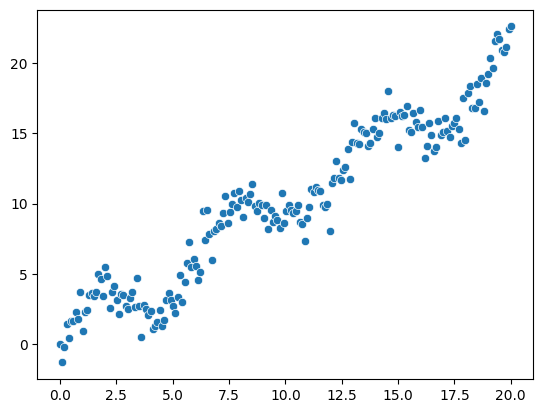

In [ ]:
X = np.linspace(0, 20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [ ]:
def train_simple_network_old(model, loss_func, training_loader, epochs=20, device="cpu"): 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)                    

    model.to(device)                                                             

    for epoch in tqdm(range(epochs), desc="Epoch"):                              
        model = model.train()                                                    
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):  
            inputs = moveTo(inputs, device)                                      
            labels = moveTo(labels, device)                                      

            optimizer.zero_grad()                                                


            y_hat = model(inputs)                                                

            loss = loss_func(y_hat, labels)                                      
            loss.backward()                                                      
            optimizer.step()                                                     
            running_loss += loss.item()    

Epoch: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


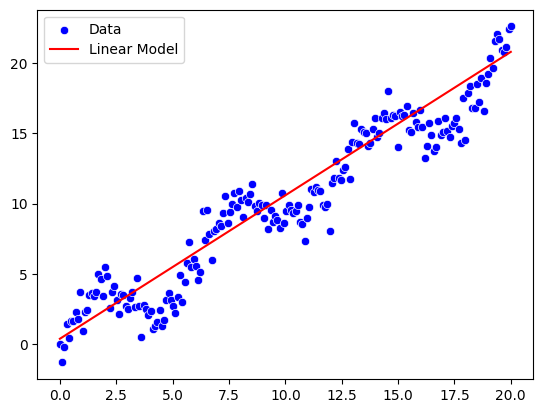

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
)
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device('cuda')
train_simple_network_old(model, loss_func, training_loader, device=device)

with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(y.reshape(1, -1))
y_transformed = scaler.transform(y.reshape(1, -1))

Epoch: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


ValueError: non-broadcastable output operand with shape (200,1) doesn't match the broadcast shape (200,200)

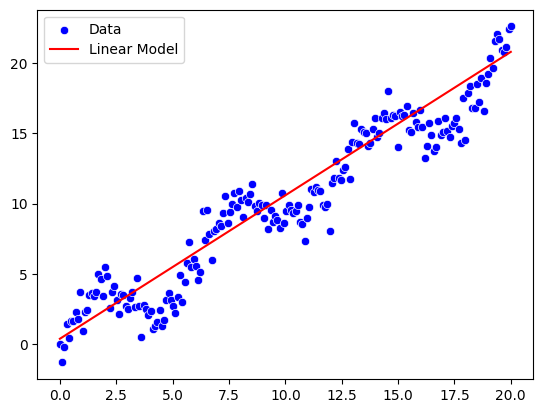

In [ ]:
model = nn.Sequential(
    nn.Linear(1,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 1),
)
training_loader = DataLoader(Simple1DRegressionDataset(X, y_transformed), shuffle=True)
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device('cuda')
train_simple_network_old(model, loss_func, training_loader, device=device)



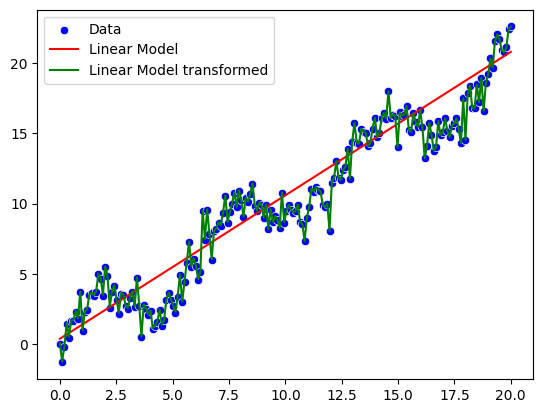

In [ ]:
with torch.no_grad():
    y_pred_transform = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    y_pred_transform = model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')
    y_rev = scaler.inverse_transform(y_pred_transform.reshape(1, -1))
    sns.lineplot(x=X, y=y_rev.ravel(), color='green', label='Linear Model transformed')